# Detrended WLC corner plots

## Setup

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import corner
import json
import pathlib
import pickle
import utils
import warnings

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = utils.plot_params()
plt.rcParams.update(params)

<IPython.core.display.Javascript object>

## [Dowload data](https://www.dropbox.com/sh/biczfd95cz7ygot/AACBp6LgmFqFcYCkySwfo8qIa?dl=1) (same dataset used for detrended WLCs)

This should be placed in a folder named `data` in the same level as this notebook

## Finish set-up

In [3]:
# Link dirs
! ln -srf data/detrended_wlcs data/detrended_wlcs_corners

<IPython.core.display.Javascript object>

## Plot

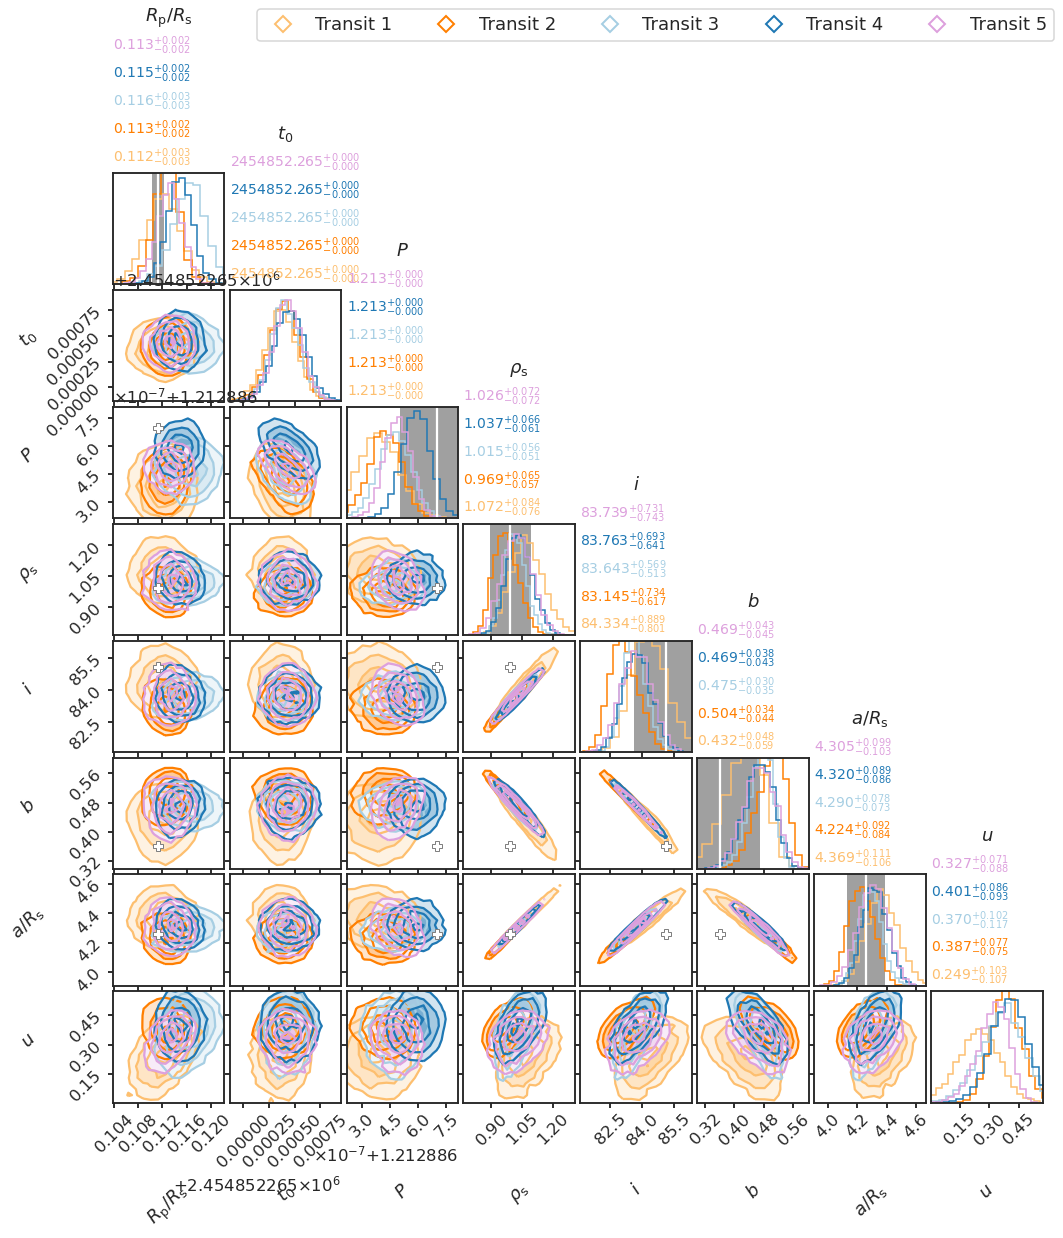

<IPython.core.display.Javascript object>

In [3]:
# Load
data_dir = "data/detrended_wlcs_corners"
fpath_truths = f"{data_dir}/truth.json"
with open(fpath_truths) as f:
    params_dict = json.load(f)

fpaths = sorted(glob.glob(f"{data_dir}/hp*/white-light/BMA_posteriors.pkl"))
data_dict = {
    f"Transit {i}": utils.load_pickle(fpath)
    for (i, fpath) in enumerate(fpaths, start=1)
}

# Plot
fig = None  # Initialize figure
for t_i, (transit_name, data) in enumerate(data_dict.items()):
    # Load
    if "rho" not in data.keys():
        G = const.G.cgs.value
        aR = data["aR"]
        P = data["P"]
        data["rho"] = 3.0 * np.pi * aR ** 3 / (G * (P * 86400.0) ** 2)
    samples = pd.DataFrame({k: v for (k, v) in data.items() if "xc" not in k})[
        params_dict.keys()
    ]

    mins = np.min(np.array([samples.min(), samples.min()]), axis=0)
    maxs = np.min(np.array([samples.max(), samples.max()]), axis=0)
    ranges = list(zip(mins, maxs))

    # Plot
    fig, axes = utils.plot_corner(
        samples, fpath_truths, c=f"C{t_i}", fig=fig, ranges=ranges
    )

    # Custom titles
    ps = [0.16, 0.5, 0.84]
    ps_strs = [f"{p*100:.0f}%" for p in ps]
    df_stats = samples.describe(percentiles=ps).loc[ps_strs]
    df_latex = pd.DataFrame(columns=df_stats.columns)
    df_latex.loc["p"] = df_stats.loc["50%"]
    df_latex.loc["p_u"] = df_stats.loc["84%"] - df_stats.loc["50%"]
    df_latex.loc["p_d"] = df_stats.loc["50%"] - df_stats.loc["16%"]

    titles = df_latex.apply(utils.write_latex_row, axis=0).to_list()

    ndim = samples.shape[1]
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i, (param_key, param_data) in enumerate(params_dict.items()):
        ax = axes[i, i]  # select 1d hist
        ax.annotate(
            f"${titles[i]}$",
            xy=(0.0, 1.1 + t_i / 4.0),
            xycoords="axes fraction",
            ha="left",
            color=f"C{t_i}",
            fontsize=14,
        )

# Label custom titles
for i, (param_key, param_data) in enumerate(params_dict.items()):
    ax = axes[i, i]  # select 1d hist
    ax.annotate(
        f"{param_data['symbol']}",
        xy=(0.5, 1.1 + (t_i + 1) / 4.0),
        xycoords="axes fraction",
        ha="center",
        # color="w",
    )
    p_mean, p_u, p_d = param_data["truth"]  # Unpack mean +/-
    ax.axvspan(p_mean - p_u, p_mean + p_u, alpha=0.75, color="grey", lw=0, zorder=0)
    ax.axvline(p_mean, color="w")

# True values
truths = [v["truth"][0] for v in params_dict.values()]
ndim = len(truths)
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.plot(truths[xi], truths[yi], "P", ms=10, mec="grey", mfc="w")

# Custom legend
handles, labels = [], []
for transit_name in list(data_dict.keys()):
    (dummy,) = plt.plot([], [], "D", ms=12, mfc="none", mew=2, label=transit_name)
    handles.append(dummy)
    labels.append(transit_name)
fig.legend(handles, labels, loc=1, fontsize=18, ncol=len(data_dict) + 1)

# Save
fig.set_size_inches(14, 14)
utils.savefig(f"../paper/figures/detrended_wlcs_corners/corner_wlcs.pdf")

[Other notebooks](https://icweaver.github.io/HAT-P-23b/)